# Learning ML for fun and profit

### The goal 
As backend engineers working in ML teams and we would like to learn some ML basics.

### The task 
When user uploads an item with multiple photos, we want to check which one has the highest chance to result in a sale.

### The plan

![alt text](https://i.imgflip.com/3n2cwx.jpg "Logo Title Text 1")

### The plan (for realz)
1. Collect data

| photo | sale | price |
|-------|------|-------|
| bytes | 1    | 10    |
| bytes | 0    | 5     |

2. Train the model to predict SALE/NO_SALE from photo data using transfer learning
3. If we get here, iterate and improve

## THE CODE

### Env setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [165]:
#!pip install -q -U toai pydot graphviz
#!apt-get -s -y install graphviz

You should consider upgrading via the 'pip install --upgrade pip' command.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig fontconfig-config fonts-dejavu-core fonts-liberation libann0
  libbsd0 libcairo2 libcdt5 libcgraph6 libdatrie1 libfontconfig1 libgd3
  libgraphite2-3 libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libharfbuzz0b
  libice6 libjbig0 liblab-gamut1 libltdl7 libpango-1.0-0 libpangocairo-1.0-0
  libpangoft2-1.0-0 libpathplan4 libpixman-1-0 libsm6 libthai-data libthai0
  libtiff5 libwebp6 libx11-6 libx11-data libxau6 libxaw7 libxcb-render0
  libxcb-shm0 libxcb1 libxdmcp6 libxext6 libxmu6 libxpm4 libxrender1 libxt6
  ucf x11-common
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig fontconfig-config fonts-dejavu-core fonts-liberation graphviz
  libann0 libbsd0 libcairo2 libcdt5 libcgraph6 libdatrie1 libfon

In [56]:
from toai.imports import *
from toai.data import DataBundle, DataParams, DataContainer
# from toai.image import ImageParser, ImageScaler
import tensorflow as tf
from tensorflow import keras
from typing import *
from numpy import repeat

In [4]:
print(__import__("toai").__version__)
print(__import__("tensorflow").__version__)

0.3.9
2.0.0


### Utils

In [ ]:
@attr.s(auto_attribs=True)
class ImageParser:
    n_channels: int = 3

    def __call__(self, filename: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        image = tf.image.decode_jpeg(
            tf.io.read_file(filename), channels=self.n_channels
        )
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image, label

In [12]:
@attr.s(auto_attribs=True)
class ImageResizer:
    img_dims: Tuple[int, int, int]
    resize: Optional[str] = None
    crop_adjustment: float = 1

    def __call__(self, image: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        height, width, _ = self.img_dims
        if self.resize == "stretch":
            image = tf.image.resize(image, (height, width))
        elif self.resize == "crop":
            crop_height, crop_width = [
                int(x * self.crop_adjustment) for x in (height, width)
            ]
            image = tf.image.resize(
                images=image, size=(crop_height, crop_width), preserve_aspect_ratio=True
            )
            image = tf.image.resize_with_crop_or_pad(image, height, width)
        elif self.resize == "random_crop":
            crop_height, crop_width = [
                int(x * self.crop_adjustment) for x in (height, width)
            ]
            image = tf.image.resize(image, (crop_height, crop_width))
            image = tf.image.random_crop(image, self.img_dims)

        return image, label

### Data cleansing, preprocessing

In [5]:
DATA_FOLDER = "/tf/eng-week-2020Q1"
LABELS_FILENAME = "photo_ids.csv"
PHOTOS_FOLDER = "data/images"

In [6]:
WORKING_DIR = Path(DATA_FOLDER)
PHOTOS_DIR = WORKING_DIR / PHOTOS_FOLDER
LABELS_FILE = WORKING_DIR / LABELS_FILENAME

In [7]:
photo_files = list(PHOTOS_DIR.glob("*"))

In [8]:
BATCH_SIZE = 32
SHUFFLE_SIZE = 1024
IMG_DIMS = (299, 299, 3)

In [10]:
dataframe = pd.read_csv(LABELS_FILE, low_memory=False, names=['uuid', 'price', 'sale'])

In [13]:
doesnt_exist = []
for index, row in dataframe.iterrows():
    uuid = row["uuid"]
    file = PHOTOS_DIR / uuid
    if not file.exists():
        doesnt_exist.append(index)

In [27]:
cleaned_df = dataframe.drop(doesnt_exist)
uuid_list = list(cleaned_df["uuid"])
labels = list(cleaned_df["sale"])

In [28]:
train_dataframe, test_dataframe = train_test_split(cleaned_df, test_size=0.2)
test_dataframe, validation_dataframe = train_test_split(test_dataframe, test_size=0.5)

In [29]:
train_data = (
    tf.data.Dataset.from_tensor_slices((f"{str(PHOTOS_DIR)}/" + train_dataframe["uuid"], train_dataframe["sale"]))
    .map(map_func=ImageParser())
    .map(map_func=ImageResizer(IMG_DIMS, "stretch"))
    # add mapping for image augmentor from toai lib, use augmentation = 6 and label is = 0
    .repeat()
    .shuffle(SHUFFLE_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [30]:
validation_data = (
    tf.data.Dataset.from_tensor_slices(
        (f"{str(PHOTOS_DIR)}/" + validation_dataframe["uuid"], validation_dataframe["sale"]))
    .map(map_func=ImageParser())
    .map(map_func=ImageResizer(IMG_DIMS, "stretch"))
    .batch(BATCH_SIZE)
)

In [31]:
test_data = (
    tf.data.Dataset.from_tensor_slices((f"{str(PHOTOS_DIR)}/" + test_dataframe["uuid"], test_dataframe["sale"]))
    .map(map_func=ImageParser())
    .map(map_func=ImageResizer(IMG_DIMS, "stretch"))
    .batch(BATCH_SIZE)
)

### Model architecture and training

#### Initial version

```
model = tf.keras.Sequential([
    keras.applications.Xception(input_shape=IMG_DIMS, include_top=False),
    keras.layers.GlobalMaxPooling2d(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation=activations.sigmoid)
    
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
              loss=keras.losses.BinaryCrossentropy(label_smoothing=0.2),
              metrics=['accuracy'])    
])

```

Poor results :( 

#### Some improvements
* Label smoothing. This is a technique to reduce model overconfidence.
* Use both max and average global pooling. Some math I don't understand. Smart people usually use one of these approaches. Turns out using both can be even better ¯\_(ツ)_/¯

In [34]:
def make_model():
    base = keras.applications.Xception(include_top=False, input_shape=IMG_DIMS)
    max_pool = keras.layers.GlobalMaxPooling2D()(base.output)
    avg_pool = keras.layers.GlobalAveragePooling2D()(base.output)
    concat = keras.layers.Concatenate()([max_pool, avg_pool])
    batch_norm = keras.layers.BatchNormalization()(concat)
    dropout = keras.layers.Dropout(0.4)(batch_norm)
    output = keras.layers.Dense(1, activation=keras.activations.sigmoid)(dropout)
    return keras.Model(inputs=base.inputs, outputs=output)
                                         

In [35]:
model = make_model()

In [40]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
              loss=keras.losses.BinaryCrossentropy(label_smoothing=0.2),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [42]:
model.fit(
    train_data,
    epochs=5,
    validation_data=validation_data,
    steps_per_epoch=math.ceil(train_dataframe.shape[0] / BATCH_SIZE),
)

Train for 497 steps, validate for 63 steps
Epoch 1/5
497/497 [==============================] - 256s 515ms/step - loss: 0.5305 - accuracy: 0.8177 - val_loss: 0.7191 - val_accuracy: 0.5817
Epoch 2/5
497/497 [==============================] - 247s 496ms/step - loss: 0.4560 - accuracy: 0.9020 - val_loss: 0.7654 - val_accuracy: 0.5726
Epoch 3/5
497/497 [==============================] - 247s 497ms/step - loss: 0.4109 - accuracy: 0.9540 - val_loss: 0.7610 - val_accuracy: 0.5732
Epoch 4/5
497/497 [==============================] - 246s 495ms/step - loss: 0.3896 - accuracy: 0.9738 - val_loss: 0.7622 - val_accuracy: 0.5817
Epoch 5/5
497/497 [==============================] - 247s 497ms/step - loss: 0.3819 - accuracy: 0.9798 - val_loss: 0.7494 - val_accuracy: 0.5837


In [43]:
print(classification_report(
    y_true=validation_dataframe["sale"],
    y_pred=model.predict(validation_data)[:, 0] > 0.5,
))

              precision    recall  f1-score   support

           0       0.60      0.54      0.57      1013
           1       0.57      0.63      0.60       976

    accuracy                           0.58      1989
   macro avg       0.59      0.58      0.58      1989
weighted avg       0.59      0.58      0.58      1989



In [133]:
test_imgs_dir = WORKING_DIR / "test_imgs"
list(test_imgs_dir.glob("*"))

[PosixPath('/tf/eng-week-2020Q1/test_imgs/crocs'),
 PosixPath('/tf/eng-week-2020Q1/test_imgs/original'),
 PosixPath('/tf/eng-week-2020Q1/test_imgs/blur'),
 PosixPath('/tf/eng-week-2020Q1/test_imgs/floor'),
 PosixPath('/tf/eng-week-2020Q1/test_imgs/inverted'),
 PosixPath('/tf/eng-week-2020Q1/test_imgs/ripple'),
 PosixPath('/tf/eng-week-2020Q1/test_imgs/cropped')]

In [134]:
test_img_paths = [str(p) for p in list(test_imgs_dir.glob("*"))]
fake_labels = repeat(0, 7)

test_imgs = (
    tf.data.Dataset.from_tensor_slices((test_img_paths, fake_labels))
    .map(map_func=ImageParser())
    .map(map_func=ImageResizer(IMG_DIMS, "stretch"))
    .batch(BATCH_SIZE)
)

In [158]:
images = [img for img, _ in test_imgs.take(5)]
numpyified_imgs = [i.numpy() for i in images[0]]

### Results demo

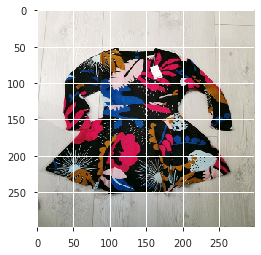

In [146]:
plt.imshow(numpyified[1])

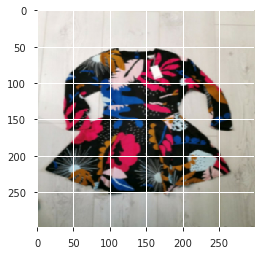

In [147]:
plt.imshow(numpyified[2])

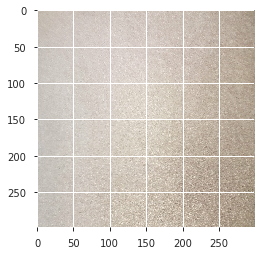

In [148]:
plt.imshow(numpyified[3])

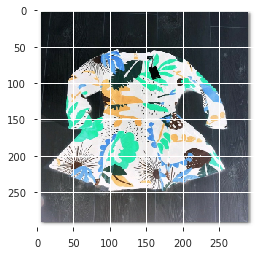

In [149]:
plt.imshow(numpyified[4])

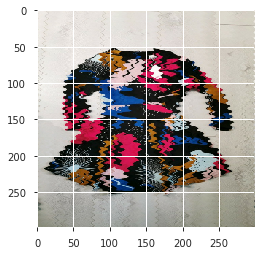

In [150]:
plt.imshow(numpyified[5])

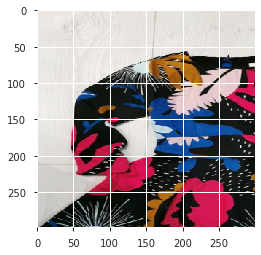

In [151]:
plt.imshow(numpyified[6])

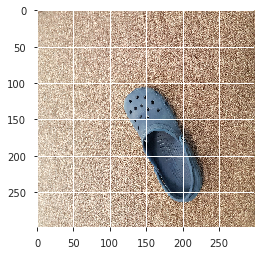

In [159]:
plt.imshow(numpyified[0])

In [152]:
predictions = model.predict(test_imgs)

In [160]:
keys = ['crocs', 'original', 'blurred', 'floor', 'inverted', 'ripple', 'cropped']
vals = [a[0] for a in predictions]
dict(zip(keys, vals))

{'crocs': 0.62120366,
 'original': 0.8695329,
 'blurred': 0.6981886,
 'floor': 0.18394956,
 'inverted': 0.7316488,
 'ripple': 0.5973915,
 'cropped': 0.82441086}